In [1]:
!pip install tensorflow gradio matplotlib seaborn scikit-learn pillow

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import gradio as gr
import time
import datetime

In [3]:
trainpath = r'C:\Users\dell\Downloads\archive\modified-dataset\train'
validpath = r'C:\Users\dell\Downloads\archive\modified-dataset\val'
testpath  = r'C:\Users\dell\Downloads\archive\modified-dataset\test'

In [4]:
datatrain = tf.keras.utils.image_dataset_from_directory(trainpath, shuffle=True, image_size=(128, 128), batch_size=32)

Found 2400 files belonging to 10 classes.


In [5]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath, shuffle=True, image_size=(128, 128), batch_size=32)

Found 300 files belonging to 10 classes.


In [6]:
datatest  = tf.keras.utils.image_dataset_from_directory(testpath,  shuffle=False, image_size=(128, 128), batch_size=32)

Found 300 files belonging to 10 classes.


In [7]:
class_names = datatrain.class_names
print("Classes:", class_names)

Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


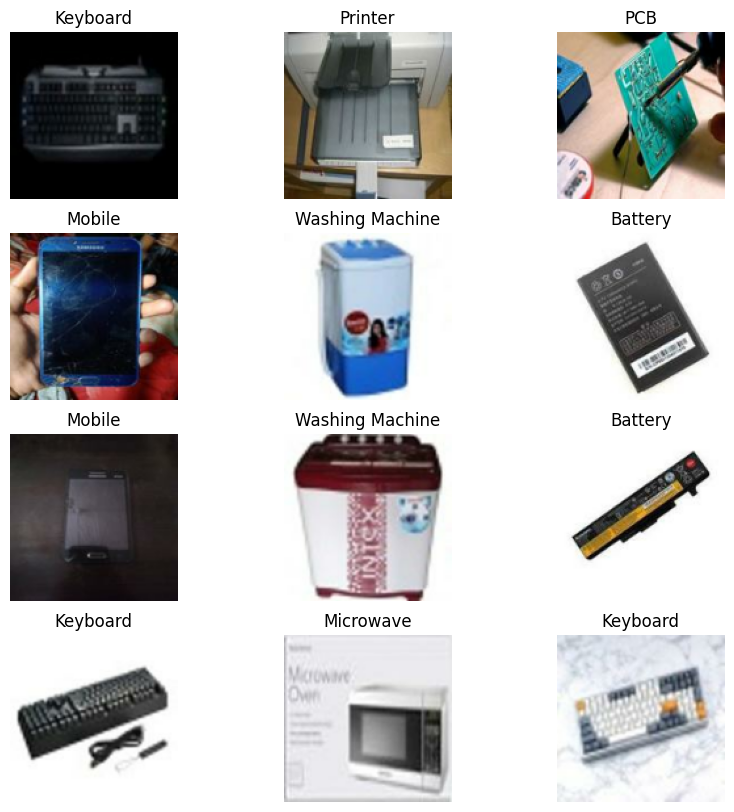

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in datatrain.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
def plot_class_distribution(dataset, title="Class Distribution"):
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

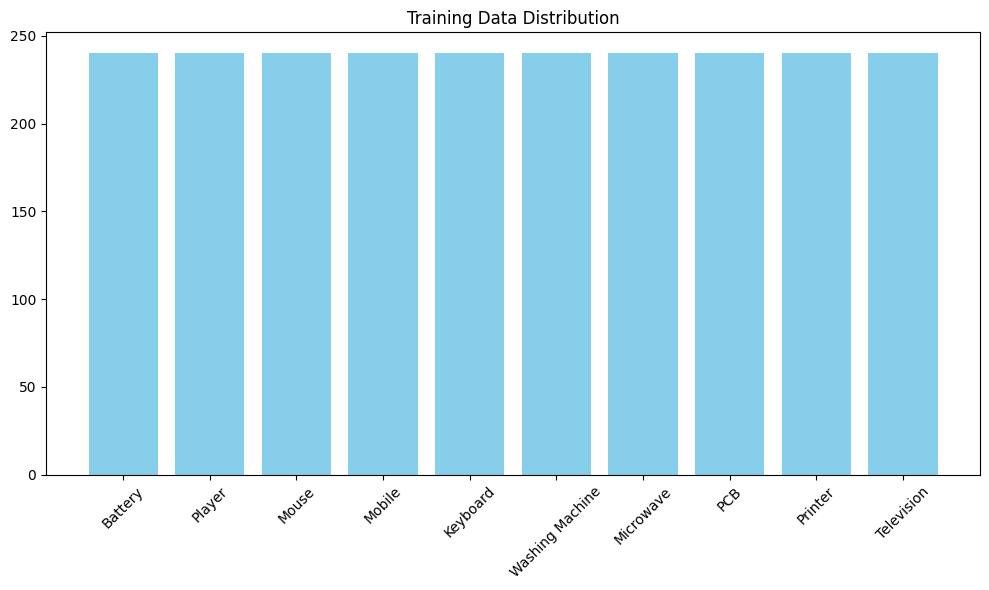

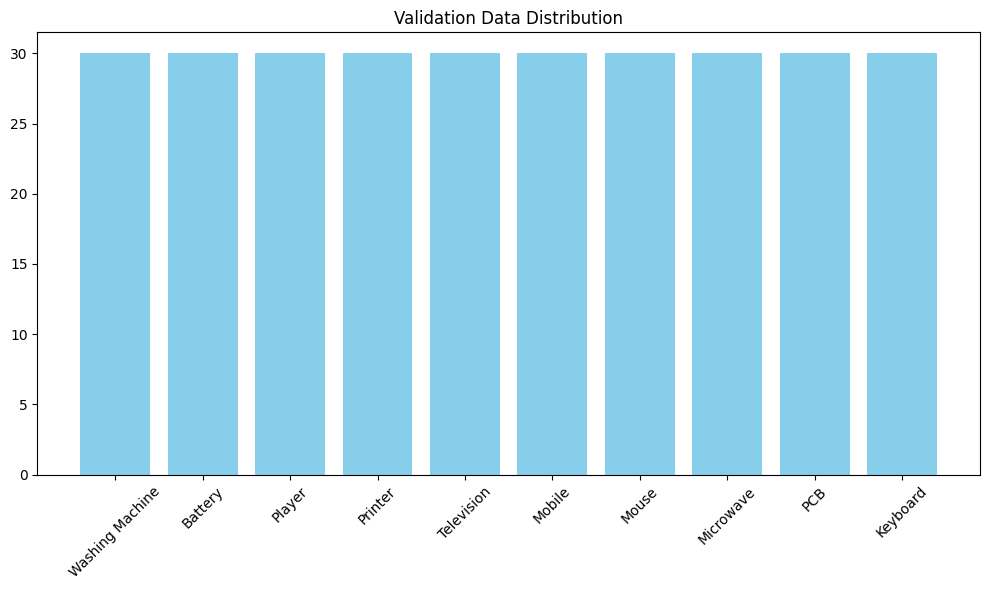

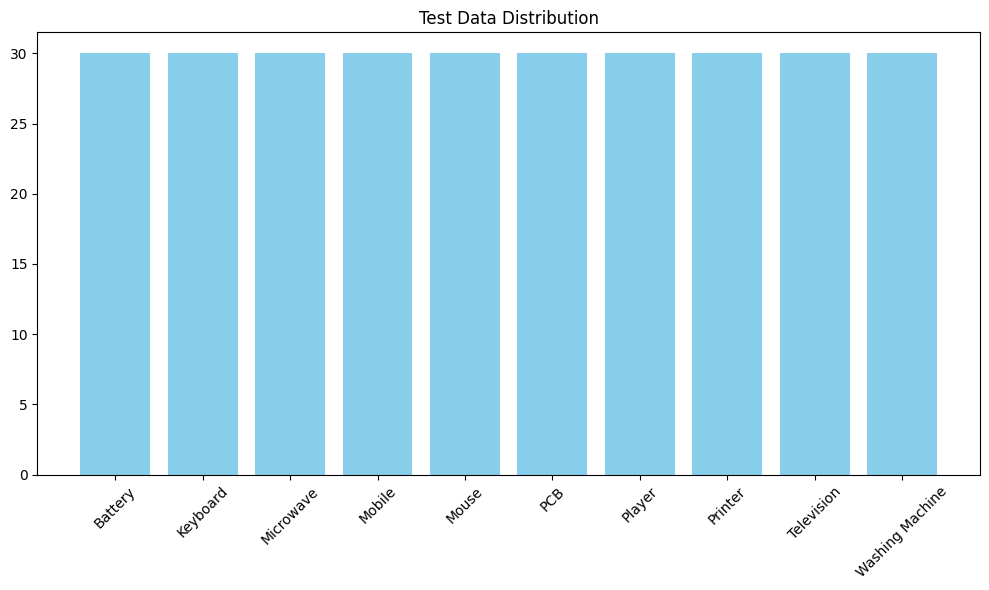

In [10]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [12]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze initial 100 layers
    layer.trainable = False

In [13]:
model = Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # Adjust based on number of classes
])

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [15]:
early = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [16]:
start_time = time.time()

history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=15,
    callbacks=[early, checkpoint, lr_scheduler]
)

end_time = time.time()
print("Training completed in:", datetime.timedelta(seconds=end_time - start_time))

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 121s 959ms/step - accuracy: 0.2039 - loss: 2.2133 - val_accuracy: 0.6833 - val_loss: 1.4160 - learning_rate: 1.0000e-04
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 887ms/step - accuracy: 0.6607 - loss: 1.2771 - val_accuracy: 0.8567 - val_loss: 0.7251 - learning_rate: 1.0000e-04
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 889ms/step - accuracy: 0.7818 - loss: 0.7723 - val_accuracy: 0.9067 - val_loss: 0.4309 - learning_rate: 1.0000e-04
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 886ms/step - accuracy: 0.8460 - loss: 0.5289 - val_accuracy: 0.9133 - val_loss: 0.3283 - learning_rate: 1.0000e-04
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 882ms/step - accuracy: 0.8771 - loss: 0.3858 - val_accuracy: 0.9300 - val_loss: 0.2568 - learning_rate: 1.0000e-04
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 882ms/step - accuracy: 0.8992 - loss: 0.3380 - val_accuracy: 0.9300 - val_loss: 0.2425 - learning_rate: 1.0000e-04
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 883ms/step - ac

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 4, 4, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [18]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 128, 128, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 128, 128, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 64, 64, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 64, 64, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 64, 64, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 64, 64, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 64, 64, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 64, 64, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 32, 32, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 32, 32, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 32, 32, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 32, 32, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 32, 32, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2b_expand_conv (Conv2D)  │ (None, 32, 32, 128)       │          36,86

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

Text(0.5, 1.0, 'Accuracy')

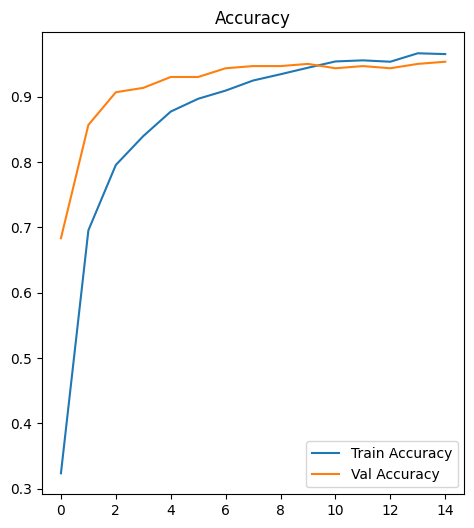

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

Text(0.5, 1.0, 'Loss')

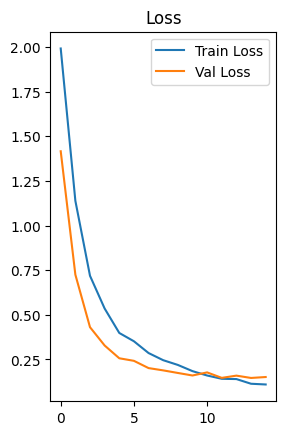

In [21]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")

In [22]:
plt.show()

In [23]:
test_loss, test_acc = model.evaluate(datatest)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.9291 - loss: 0.1951
Test Accuracy: 0.9467, Test Loss: 0.1522


In [28]:
y_true = np.concatenate([y.numpy() for x, y in datatest])
y_pred_probs = model.predict(datatest)
y_pred = np.argmax(y_pred_probs, axis=1)
print(confusion_matrix(y_true, y_pred))                            

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
[[26  0  0  0  0  1  3  0  0  0]
 [ 1 28  0  0  0  1  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  1  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  0  0  1  0 28  0  0  0]
 [ 1  0  0  0  0  0  1 28  0  0]
 [ 0  1  1  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]


In [25]:
print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

        Battery       0.90      0.87      0.88        30
       Keyboard       0.97      0.93      0.95        30
      Microwave       0.97      0.97      0.97        30
         Mobile       1.00      0.97      0.98        30
          Mouse       0.97      0.97      0.97        30
            PCB       0.91      0.97      0.94        30
         Player       0.85      0.93      0.89        30
        Printer       0.97      0.93      0.95        30
     Television       0.97      0.93      0.95        30
Washing Machine       1.00      1.00      1.00        30

       accuracy                           0.95       300
      macro avg       0.95      0.95      0.95       300
   weighted avg       0.95      0.95      0.95       300



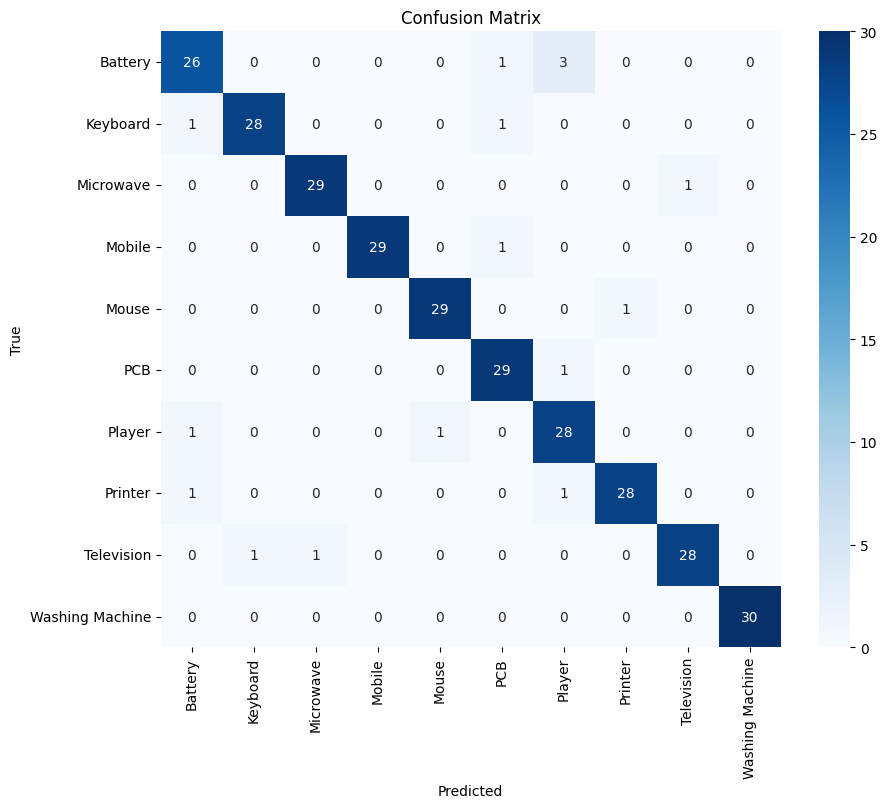

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


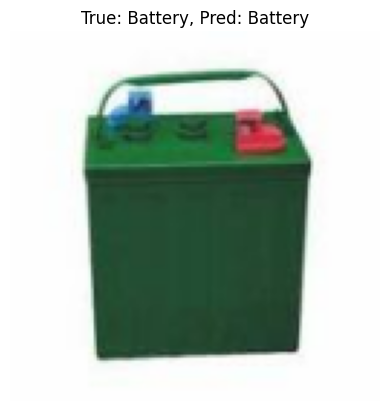

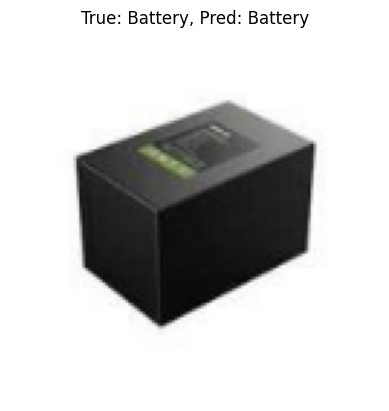

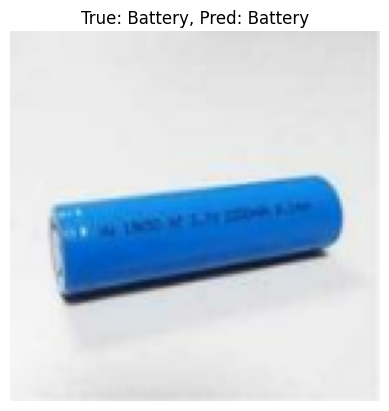

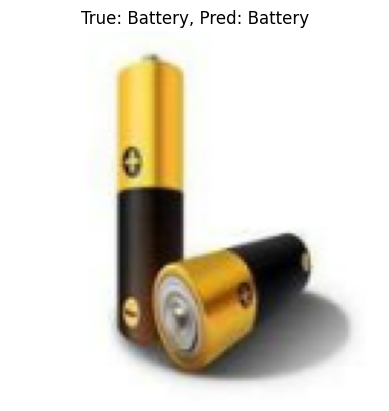

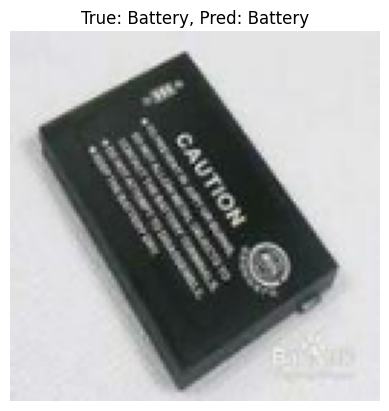

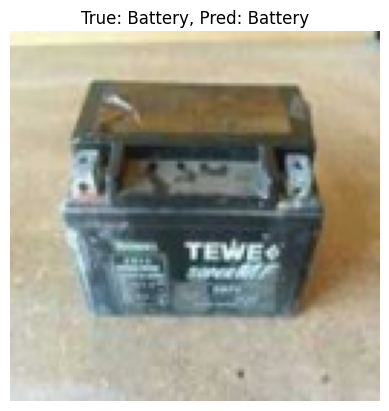

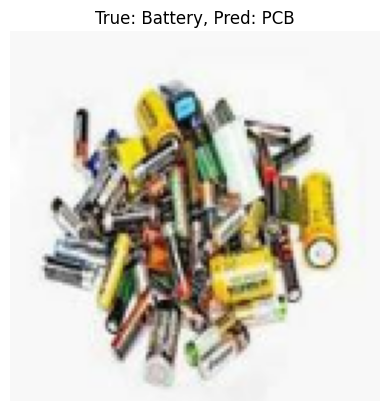

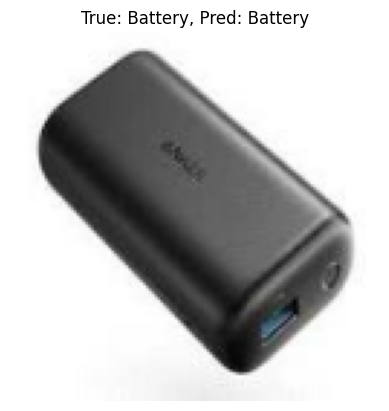

In [29]:
for images, labels in datatest.take(1):
    preds = model.predict(images)
    pred_classes = tf.argmax(preds, axis=1)

    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_classes[i]]}")
        plt.axis("off")
        plt.show()

In [30]:
model.save("Efficient_classify.keras")
model = tf.keras.models.load_model("Efficient_classify.keras")

In [32]:
!pip install gradio --upgrade

In [43]:
import gradio as gr
import numpy as np
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('Efficient_classify.keras')

# Define class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

In [64]:
# Prediction function
def classify_image(img):
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index]
    
    return f"### 🧠 Prediction: **{class_name}**\n#### 🔍 Confidence: **{confidence:.2%}**"

In [65]:
# Interface setup
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="📤 Upload Electronic Item Image"),
    outputs=gr.Textbox(label="📊 Prediction Result"),  # ✅ Change here
    title="🔌 E-Waste Image Classifier",
    description="Upload an image and get an instant prediction with confidence using EfficientNetV2B0.",
    theme="soft",
    flagging_mode="never"
)

In [66]:
iface.launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
